In [281]:
import numpy as np
import matplotlib.pyplot as plt

class jenkins():
    
    def __init__(self, X_target, X_contact, normal, k=2, mu=0.1):
        
        # contact properties
        self.k = k
        
        self.mu = mu
        
        #contact parameters
        self.X_target = X_target
        self.X_contact = X_contact
        self.normal = normal
        
        self.alpha = np.zeros(X_target.shape)
        self.gap_n = np.zeros(X_target.shape)
        
    def compute_gap_and_tangent(self, u):
        
        dim = u.shape[0]
        if dim%2:
            raise ValueError('Displacement vector is not compatible')

        u_target = u[:int(dim/2)]
        u_contact = u[int(dim/2):]
        
        x_contact = self.X_contact + u_contact
        x_target = self.X_target + u_target
        
        delta = x_contact - x_target
        gap = self.normal.dot(delta)
        u_tangent = gap*self.normal - delta
        
        if gap <=0.0:
            return gap, u_tangent
        else:
            return gap*0.0, u_tangent
    
    def compute_tangent_force(self,tangent,N):
        
        delta_gap = tangent - self.gap_n
        self.gap_n = tangent
        Ft_trial = self.alpha - self.k*delta_gap 
        norm_Ft_trial = np.linalg.norm(Ft_trial)
        if norm_Ft_trial>0:
            d = Ft_trial/norm_Ft_trial
        else:
            d = 1.0

        Phi = norm_Ft_trial - self.mu*N
        if Phi<=0:
            self.alpha = Ft_trial
            return self.alpha
        
        else:
            self.alpha = self.mu*N*d
            return self.alpha
        
    def compute(self,u):
        
        gap, u_tangent = self.compute_gap_and_tangent(u)
        N = -self.k*gap
        normal_force = N*self.normal
        tangent_force = self.compute_tangent_force(u_tangent,N)
        force = normal_force + tangent_force
        return np.concatenate([force,-force])

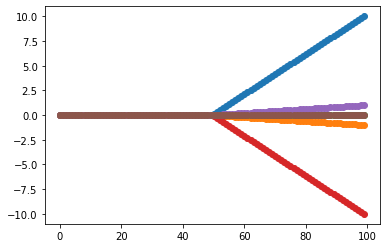

In [204]:
X_target = np.array([0.,0.,0.])
X_contact = np.array([0.5,0.,0.])
normal = np.array([1.0,0.0,0.0])
contact = jenkins(X_target, X_contact, normal,mu=0.15,k=20)



base_u = np.array([1.,0.1,0.,0.,0.,0.])
contact_force = lambda a : contact.compute(a*base_u)

force_list = list(map(contact_force,np.linspace(0,1,100)))

plt.plot(force_list,'o')
plt.show()

In [23]:
from pyfeti import utils

import amfe

In [36]:
d1 = utils.DomainCreator(width=1,heigh=1,x_divisions=3,y_divisions=3,start_x =0,start_y=0,domain_id=1)
mesh_file_1 = 'domain_1.msh'
d1.save_gmsh_file(mesh_file_1)
m = amfe.Mesh()
m.import_msh(mesh_file_1)

In [37]:
m1 = m
m2 = m.translation(np.array([1.2,0.,0.]))


(-0.5, 1.5)

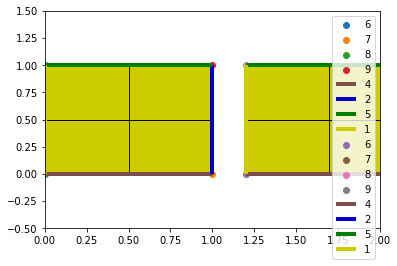

In [40]:
ax1 = amfe.plot2Dmesh(m1)
amfe.plot2Dmesh(m2,ax=ax1)

ax1.set_xlim([0,2])
ax1.set_ylim([-0.5,1.5])

In [41]:
m1.nodes

array([[0. , 0. ],
       [0.5, 0. ],
       [1. , 0. ],
       [0. , 0.5],
       [0.5, 0.5],
       [1. , 0.5],
       [0. , 1. ],
       [0.5, 1. ],
       [1. , 1. ]])

In [42]:
m2.nodes

array([[1.2, 0. ],
       [1.7, 0. ],
       [2.2, 0. ],
       [1.2, 0.5],
       [1.7, 0.5],
       [2.2, 0.5],
       [1.2, 1. ],
       [1.7, 1. ],
       [2.2, 1. ]])

In [45]:
m1.split_in_groups()
m2.split_in_groups()

d1 = m1.get_submesh('phys_group',3)
d2 = m2.get_submesh('phys_group',3)

In [206]:
contact = amfe.contact.Contact(d1,d2,tol_radius=0.5)

master_nodes = contact.master_nodes
slave_nodes = contact.slaves_nodes

It was not possible to find a slave node for master node 0. Minimum distance is 1.200000e+00
It was not possible to find a slave node for master node 1. Minimum distance is 7.000000e-01
It was not possible to find a slave node for master node 3. Minimum distance is 1.200000e+00
It was not possible to find a slave node for master node 4. Minimum distance is 7.000000e-01
It was not possible to find a slave node for master node 6. Minimum distance is 1.200000e+00
It was not possible to find a slave node for master node 7. Minimum distance is 7.000000e-01


In [207]:
master_nodes

[2, 5, 8]

In [208]:
slave_nodes

[0, 3, 6]

In [209]:
contact.contact_elem_dict

{2: 0, 5: 3, 8: 6}

In [210]:
def map_local2global_dofs(global_vector, local_index, local_values):
    global_vector[local_index] = local_values
    
dimension = 2
shift = 8
map_dict = {}
contact_id = 0
contact_list = []
for key, value in contact.contact_elem_dict.items():
    map_dict[contact_id] = [key*dimension,key*dimension+1,shift+value*dimension,shift+value*dimension+1] 
    X_target = m1.nodes[key]
    X_contact =  m2.nodes[value]
    normal = np.array([1.0,0.])
    jenkins_obj = jenkins(X_target, X_contact, normal)
    contact_list.append(jenkins_obj)
    contact_id +=1

In [211]:
for contact_elem in  contact_list:
    print(contact_elem.X_target)
    print(contact_elem.X_contact)

    

[1. 0.]
[1.2 0. ]
[1.  0.5]
[1.2 0.5]
[1. 1.]
[1.2 1. ]


In [212]:
class Nonlinear_force_assembler():
    def __init__(self,map_dict,contact_list):
        self.map_dict = map_dict
        self.contact_list = contact_list
        
    def compute(self,u):
        
        global_force = np.zeros(u.shape)
        for key,global_index in self.map_dict.items():
            local_force = contact_list[key].compute(u[global_index])
            global_force[global_index] = local_force
            
        return global_force
    

Fnl_obj = Nonlinear_force_assembler(map_dict,contact_list)
Fnl = lambda u : Fnl_obj.compute(u)
                

In [76]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m1)
rho = 7.85E-9 # ton/mm3
E = 2.10E5 # MPa = N/mm2
my_material = amfe.KirchhoffMaterial(E=E, nu=0.3, rho=rho, plane_stress=False)
my_comp.set_domain(3,my_material)
print('Number of nodes is equal to %i' %my_comp.mesh_class.no_of_nodes)

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 4 elements and 18 dofs.
Time taken for preallocation: 0.00 seconds.
Number of nodes is equal to 9


In [77]:
K, f_ = my_comp.assembly_class.assemble_k_and_f()

In [79]:
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager
try:
    connectivity = []
    for _,item in m.el_df.iloc[:, m.node_idx:].iterrows():
        connectivity.append(list(item.dropna().astype(dtype='int64')))
    m.el_df['connectivity'] = connectivity
except:
    pass
    
id_matrix = my_comp.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
s = create_selection_operator(id_map_df,m.el_df)

In [80]:
s.selection_dict

{1: OrderedSet([0, 1, 6, 7, 12, 13]),
 2: OrderedSet([4, 5, 10, 11, 16, 17]),
 3: OrderedSet([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]),
 4: OrderedSet([0, 1, 2, 3, 4, 5]),
 5: OrderedSet([12, 13, 14, 15, 16, 17]),
 6: OrderedSet([0, 1]),
 7: OrderedSet([4, 5]),
 8: OrderedSet([12, 13]),
 9: OrderedSet([16, 17]),
 -1: OrderedSet()}

In [83]:
from pyfeti.src.linalg import Matrix
K1 = Matrix(K,key_dict=s.selection_dict)
K2 = Matrix(K,key_dict=s.selection_dict)
K1.eliminate_by_identity(1,1.0E15)
K2.eliminate_by_identity(2,1.0E15)

/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


<18x18 sparse matrix of type '<class 'numpy.float64'>'
	with 118 stored elements in Compressed Sparse Row format>

In [213]:
import scipy.sparse as sparse
from scipy.optimize import minimize, root
dof_id = 4*2

K_global = sparse.bmat([[K1.data,None],[None,K2.data]])

def compute_u(a,x0):
    f1 = np.zeros(K1.shape[0])
    f2 = np.zeros(K2.shape[0])
    f1[dof_id] = a
    
    f_global = np.concatenate([f1,f2])
    
    
    R = lambda u : K_global.dot(u) - f_global - Fnl(u)
    
    #u_global = sparse.linalg.spsolve(K_global,f_global)
    
    sol = root(R,x0,method='hybr')
    u_global = sol.x
    half_size = int(u_global.shape[0]/2)
    u1 = u_global[:half_size]
    u2 = u_global[half_size:]
    return u1, u2


x0 = np.zeros(K_global.shape[0])
u1, u2 = compute_u(3.0E5,x0)

In [214]:
u1

array([ 0.00000000e+00,  0.00000000e+00,  1.60007675e-01,  1.86951585e-01,
        3.97011530e-01, -2.27378898e-01,  0.00000000e+00,  0.00000000e+00,
        9.81341229e-01,  2.65825569e-07,  7.27013231e-01, -2.82652736e-07,
        0.00000000e+00,  0.00000000e+00,  1.60005613e-01, -1.86951030e-01,
        3.97014310e-01,  2.27377039e-01])

In [215]:
u2

array([-3.20357466e-06,  3.68553484e-06, -3.44490231e-06,  1.80006881e-06,
        0.00000000e+00,  0.00000000e+00, -7.60780384e-07,  3.61609382e-06,
       -2.34709385e-07,  1.12293346e-06,  0.00000000e+00,  0.00000000e+00,
        1.30795587e-06,  3.26360480e-06,  9.02277771e-07,  1.27668094e-06,
        0.00000000e+00,  0.00000000e+00])

10.0


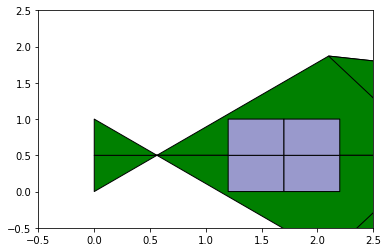

In [280]:
%notebook matplotlib

from IPython.display import HTML
from matplotlib.animation import FuncAnimation


from pyfeti import utils


fig1, ax2 = plt.subplots(1,1)


def update(i):

    p, _ = amfe.plotDeformQuadMesh(m1.connectivity,m1.nodes,u1,factor=i*1.0E0,ax=ax2)
    p, _ = amfe.plotDeformQuadMesh(m1.connectivity,m2.nodes,u2,factor=i*1.0E0,ax=ax2)
    ax2.set_xlim([-0.5,2.5])
    ax2.set_ylim([-0.5,2.5])

    print(i)
    return p,


ani = FuncAnimation(fig1, update, frames=np.linspace(10,100,10), interval=10, blit=True)  

#for i in range(1,10):
#    update(0.1*i)


In [246]:
p

In [247]:
p.set_zorder()

TypeError: set_zorder() missing 1 required positional argument: 'level'